In [1]:
setwd('../../')
source('.Rprofile')
setwd('./benchmark/analysis')

library(ggplot2)
library(tidyverse)
library(ggpubr)
library(reshape2)
library(patchwork)

i Using R 4.3.1 (lockfile was generated with R 4.1.3)
[1] "/flash/grp/gglab/xiacr/SLAT-dev/renv/library/R-4.3/x86_64-pc-linux-gnu"         
[2] "/flash/grp/gglab/xiacr/SLAT-dev/renv/sandbox/R-4.3/x86_64-pc-linux-gnu/9a444a72"
python:         /flash/grp/gglab/xiacr/SLAT-dev/conda/bin/python
libpython:      /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/libpython3.8.so
pythonhome:     /flash/grp/gglab/xiacr/SLAT-dev/conda:/flash/grp/gglab/xiacr/SLAT-dev/conda
version:        3.8.17 | packaged by conda-forge | (default, Jun 16 2023, 07:06:00)  [GCC 11.4.0]
numpy:          /flash/grp/gglab/xiacr/SLAT-dev/conda/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by use_python() function
[1] "/flash/grp/gglab/xiacr/SLAT-dev/conda/lib:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/flash/grp/gglab/xiacr/SpatialLR-dev/resource/jdk1.8.0_361/lib/server:/opt/slurm-22.05.2/lib:/opt/slurm-22.05.2/lib/slurm:/opt/slurm-23.02.5/lib:/opt/slurm-23.02.5/lib/slurm:/opt/slurm-23.

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




In [8]:
data <- read_csv('../results/benchmark.csv')
data$cells <- as.numeric(data$cells)
data <- data[data$global_score > 0,]
data <- data[data$cells == 0,] %>% filter(str_detect(method, 'one2many') | str_detect(method, 'PASTE')) %>%
        mutate(method = replace(method, method == 'SLAT_dpca_one2many', 'SLAT')) %>%
        mutate(method = replace(method, method == 'Harmony_one2many', 'Harmony')) %>%
        mutate(method = replace(method, method == 'Seurat_one2many', 'Seurat')) %>%
        mutate(method = replace(method, method == 'STAGATE_one2many', 'STAGATE'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))


data[nrow(data) + 1,] <- list("stereo_mouse_embryo",0,0,'PASTE',NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA) # PASTE can not run on Stereo-seq

data <- data %>% 
  mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
  mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
  mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq'))
data$dataset <- factor(data$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))
data %>% tail(5)

Rows: 26 Columns: 18
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): dataset, method
dbl (16): cells, seed, angle_delta, celltype_macro_f1, celltype_micro_f1, ce...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,method,angle_delta,celltype_macro_f1,celltype_micro_f1,celltype_score,edge_score,euclidean_dis,global_score,match_ratio,region_macro_f1,region_micro_f1,region_score,run_time,total_macro_f1,total_micro_f1
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Visium,0,0,PASTE,1.676417,0.7439865,0.7431296,0.7431296,-22.83287,0.05568886,0.6404936,-1,0.7850734,0.8280987,0.8280987,66.375347,0.2826078,0.6404936
Visium,0,0,SLAT,-1.000000,-1.0000000,-1.0000000,0.8250140,-1.00000,-1.00000000,0.7042457,-1,-1.0000000,-1.0000000,0.8157600,9.523365,-1.0000000,-1.0000000
Visium,0,0,STAGATE,-1.000000,-1.0000000,-1.0000000,0.7950084,-1.00000,-1.00000000,0.6191812,-1,-1.0000000,-1.0000000,0.7549075,54.482306,-1.0000000,-1.0000000
Visium,0,0,Seurat,-1.000000,-1.0000000,-1.0000000,0.6547953,-1.00000,-1.00000000,0.5179473,-1,-1.0000000,-1.0000000,0.5426248,95.151000,-1.0000000,-1.0000000
Stereo-seq,0,0,PASTE,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# confuse matrix

[1] "SLAT"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]           0.81576            0.825014         0.7042457
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.5885839           0.7963194         0.4442857
[1] "Stereo-seq"
     mean_region_score mean_celltype_score mean_global_score
[1,]          0.933341           0.7242182         0.6960019
[1] "PASTE"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8280987           0.7431296         0.6404936
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7620087           0.2819713         0.2231753
[1] "Stereo-seq"
     mean_region_score mean_celltype_score mean_global_score
[1,]                NA                  NA                NA
[1] "STAGATE"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7549075           0.7950084         0.6191812
[1] "MER

Warning message:
"Removed 4 rows containing missing values (`geom_text()`)."


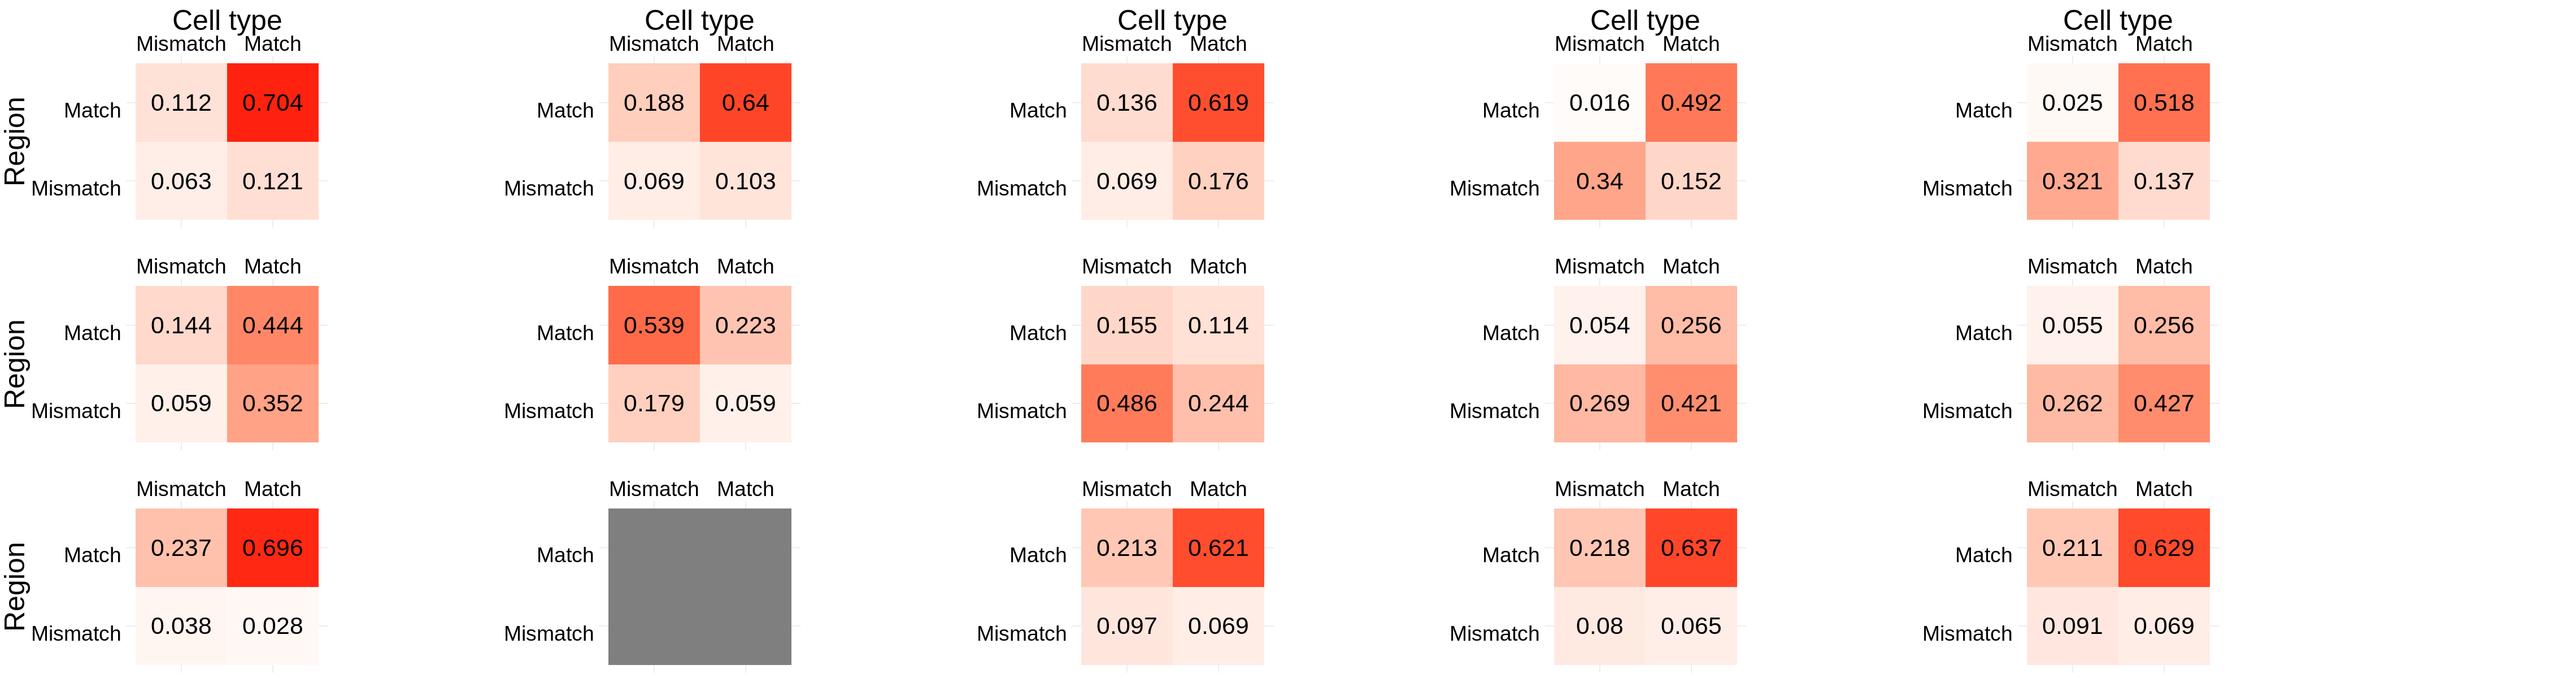

In [9]:
options(repr.plot.width=10, repr.plot.height=7)
p2_list <- list()
j <- 1 # column for methods
# for(datasets in c('Visium','MERFISH','Stereo-seq')){
for(methods in c('SLAT','PASTE','STAGATE','Harmony','Seurat')){
    i <- 1 # row for dataset
    p_list <- list()
    print(methods)
    # for(methods in c('SLAT','PASTE','STAGATE','Harmony','Seurat')){
    for(datasets in c('Visium','MERFISH','Stereo-seq')){
        print(datasets)
        data_method <- data %>% filter(method == methods, dataset == datasets)  %>% 
            summarise(mean_region_score = mean(region_score), mean_celltype_score = mean(celltype_score), mean_global_score = mean(global_score)) %>% 
            as.matrix()
        print(data_method)
        confusion_matrix <- matrix(0, nrow = 2, ncol = 2)
        confusion_matrix[2,2] <- data_method[1,3]
        confusion_matrix[1,2] <- data_method[1,1] - data_method[1,3]
        confusion_matrix[2,1] <- data_method[1,2] - data_method[1,3]
        confusion_matrix[1,1] <- 1 - confusion_matrix[1,2] - confusion_matrix[2,2] - confusion_matrix[2,1]
        rownames(confusion_matrix) <- c('Mismatch', 'Match')
        colnames(confusion_matrix) <- c('Mismatch', 'Match')
        confusion_matrix <- confusion_matrix %>% melt()
        colnames(confusion_matrix) <- c('Cell_type', 'Region', 'Ratio')
        # print(confusion_matrix)

        p <- ggplot(confusion_matrix, aes(x = Cell_type, y = Region, fill = Ratio)) + 
            geom_tile() + 
            geom_text(aes(x = Cell_type, y = Region, label = round(Ratio, digits = 3)), color = "black", size = 9) + 
            scale_fill_gradient2(low = "white", high = "red", limit = c(-0.01, 0.73)) +
            labs(x = 'Cell type', y = 'Region') + 
            scale_x_discrete(position = "top") + 
            theme_minimal() +
            theme(  text = element_text(size = 28),
                    axis.text = element_text(vjust = 1, hjust = 0.5, color = "black"),
                    axis.title = element_text(size = 30),
                    plot.title = element_text(size = 30, hjust = 0.5),
                    legend.title = element_text(size = 24),
                    axis.ticks = element_blank(),
                    plot.margin = unit(c(0,160,0,0), "pt")
                )

        if (i != 6) {p <- p + theme(legend.position = "none") }
        if (i > 1) {p <- p + labs(x='') }
        if (j > 1) {p <- p + labs(y='') }
        # if (i > 1) {p <- p + theme(plot.title = element_blank())}
        # print(p)
        p_list[[i]] <- p
        i <- i + 1
        }
    p2 <-  do.call(patchwork::wrap_plots, c(p_list, ncol = 1))
    p2_list[[j]] <- p2
    j <- j + 1
}

options(repr.plot.width = 38, repr.plot.height = 10)
do.call(patchwork::wrap_plots, c(p2_list, ncol = 6))

# Heterogenous

In [3]:
data <- read_csv('../results/benchmark_hetero.csv')
data$cells <- as.numeric(data$cells)
data <- data[data$global_score > 0,]
data <- data[data$cells == 0,] %>% filter(!method %in% c('SLAT', 'SLAT_harmony', 'PCA')) %>% 
        mutate(method = replace(method, method == 'SLAT_dpca', 'SLAT'))

data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat', 'PASTE2'))
data %>% tail(5)

data <- data %>% filter(!method %in% c('PASTE2'))

# add new column name group, if 'visium' in dataset column, then group is 'Visium', if 'merfish' in dataset column, then group is 'MERFISH'
data <- data %>% 
  mutate(method = factor(method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))) %>%
  mutate(across('dataset', str_replace, 'stereo_seqfish_embryo_9.5', 'Stereo-seq and seqFISH+')) 

Rows: 5 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): dataset, method
dbl (14): cells, seed, celltype_macro_f1, celltype_micro_f1, celltype_score,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,method,celltype_macro_f1,celltype_micro_f1,celltype_score,edge_score,euclidean_dis,global_score,region_macro_f1,region_micro_f1,region_score,run_time,total_macro_f1,total_micro_f1
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stereo_seqfish_embryo_9.5,0,0,Harmony,0.8255515,0.8362155,0.8362155,-40.41026,0.27524038,0.6557344,0.5513545,0.7511429,0.7511429,10.80082,0.32042412,0.6557344
stereo_seqfish_embryo_9.5,0,0,PASTE,0.2391488,0.3802425,0.3802425,-832.27748,0.36839280,0.3357185,0.3255023,0.5404492,0.5404492,76.71435,0.07199999,0.3357185
stereo_seqfish_embryo_9.5,0,0,SLAT,0.8342493,0.8427748,0.8427748,-36.63129,0.09867704,0.7312661,0.6292179,0.8541046,0.8541046,13.24061,0.40986978,0.7312661
stereo_seqfish_embryo_9.5,0,0,STAGATE,0.5786854,0.5976943,0.5976943,-128.61220,0.31051311,0.4742596,0.4801852,0.6569271,0.6569271,63.78149,0.19864817,0.4742596
stereo_seqfish_embryo_9.5,0,0,Seurat,0.8617170,0.8652355,0.8652355,-52.66031,0.23977797,0.6942954,0.5771358,0.7809581,0.7809581,194.75000,0.34277307,0.6942954


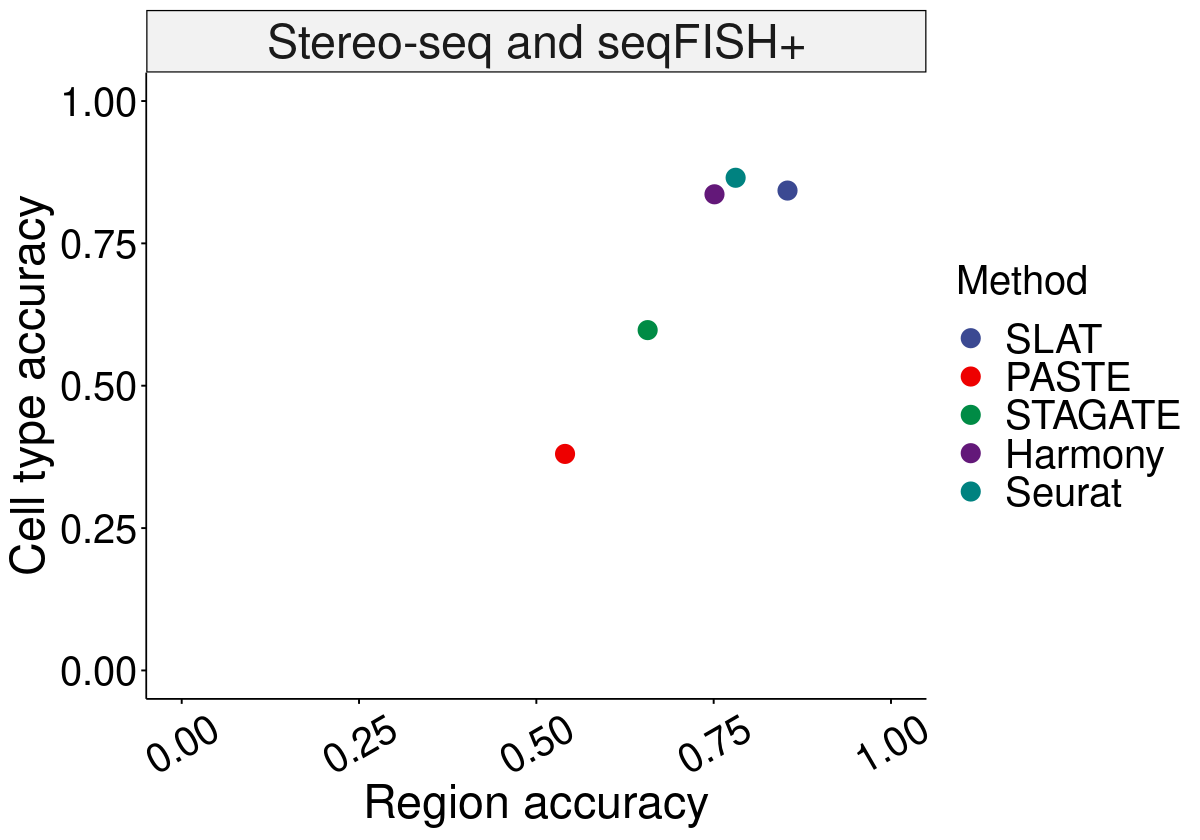

In [4]:
options(repr.plot.width=10, repr.plot.height=7)
ggscatter(data, x="region_score", y="celltype_score", color='method', size=5,
        palette='aaas', xlab='Region accuracy', ylab='Cell type accuracy', lab.size=30,
        legend.title = 'Method') %>% 
ggpar(xlim=c(0,1), ylim=c(0,1), legend='right', font.legend=24, font.subtitle=24,
    font.xtickslab=24, font.ytickslab=24, font.x=28, font.y=28) +
facet_wrap(~dataset, scales="free") +
theme(axis.text.x=element_text(angle=30, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))


Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”


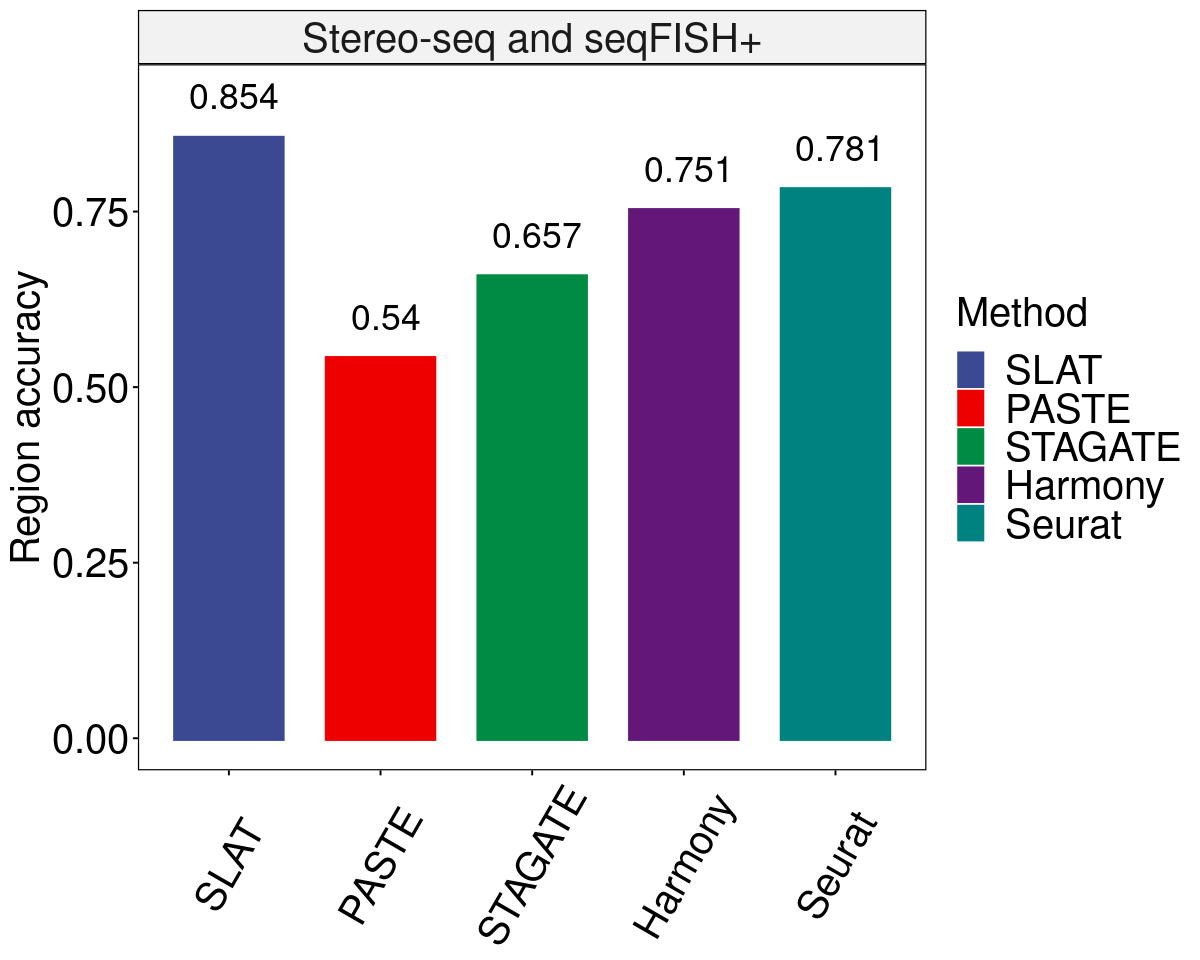

In [5]:
options(repr.plot.width=10, repr.plot.height=8)
ggbarplot(data, x="method", y="region_score", fill='method', color='method', add="mean_se", error.plot="upper_errorbar",
        palette='aaas', xlab=F ,ylab='Region accuracy', size=1.5, lab.size=5, facet.by='dataset', label=F, label.pos="out",
        legend.title='Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=24) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.06, label = paste("", round(mean(x), 3))), geom="text", size=7.5) +
facet_wrap(~dataset, scales="free") +
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=24))
